<a href="https://colab.research.google.com/github/MatheusABomfim/Mest_MBL2_ML_HTLV/blob/main/MEST_HTLV%2BMBL2%2BCLINICAL_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading data and packages**

**Packages install**

In [2]:
# Install shap
!pip install shap

  Using cached scikit-learn-1.0.2.tar.gz (6.7 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [66 lines of output]
      Partial import of sklearn during the build process.
      setup.py:128: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.command.build_ext import build_ext  # noqa
      INFO: No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
      Traceback (most recent call last):
        File "c:\Users\mathe\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_proces

   ---------------------------------------- 0.0/107.7 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/107.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 107.7/107.7 kB 1.5 MB/s eta 0:00:00


**Libraries import**

In [1]:
# Import necessary libraries and packages
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.inspection import permutation_importance

# sklearn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,
    learning_curve
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    recall_score, accuracy_score, roc_curve, auc, make_scorer,
    precision_score, f1_score
)
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,
    RobustScaler, StandardScaler
)
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier

# imbalanced-learn imports
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# joblib imports
from joblib import dump, load

# scikit-optimize imports
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# statsmodels imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# openpyxl imports
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# ipywidgets imports
from ipywidgets import interact, widgets

# shap imports
import shap
from sklearn.inspection import permutation_importance

# Ignore warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


**Data import**

In [2]:
# Path to the CSV file containing the DataFrame
combined_data_file = '..\\datasets\\df_combined.csv'

# Loading the DataFrame directly from the CSV file
df_combined = pd.read_csv(combined_data_file)

# Normalizando apenas a coluna "Idade"
scaler = MinMaxScaler()
df_combined['Idade'] = scaler.fit_transform(df_combined[['Idade']])

y = df_combined['HAM/TSP']  # Target variable
X = df_combined.drop('HAM/TSP', axis=1)  # Predictor variables

# Exibindo as primeiras linhas do DataFrame com a coluna "Idade" normalizada
display(df_combined.head())

,Sexo,Idade,MBL-550,MBL -221,MBL EXON,Sintomas urinários,Dor,Transtorno/sintomas neurológicos,HAM/TSP
0,0,0.758621,1,0,2,2,4,5,0
1,1,0.137931,0,0,1,0,0,0,0
2,0,0.517241,2,1,0,0,0,0,0
3,0,0.206897,1,0,0,0,0,0,0
4,0,0.293103,1,1,1,0,0,0,0


In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AdaBoost', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AdaBoost carregado com sucesso.
Modelo LSVM carregado com sucesso.


**Load the definitions identified for the models**

In [6]:
X.columns

Index(['Sexo', 'Idade', 'MBL-550', 'MBL -221', 'MBL EXON',
       'Sintomas urinários', 'Dor', 'Transtorno/sintomas neurológicos'],
      dtype='object')

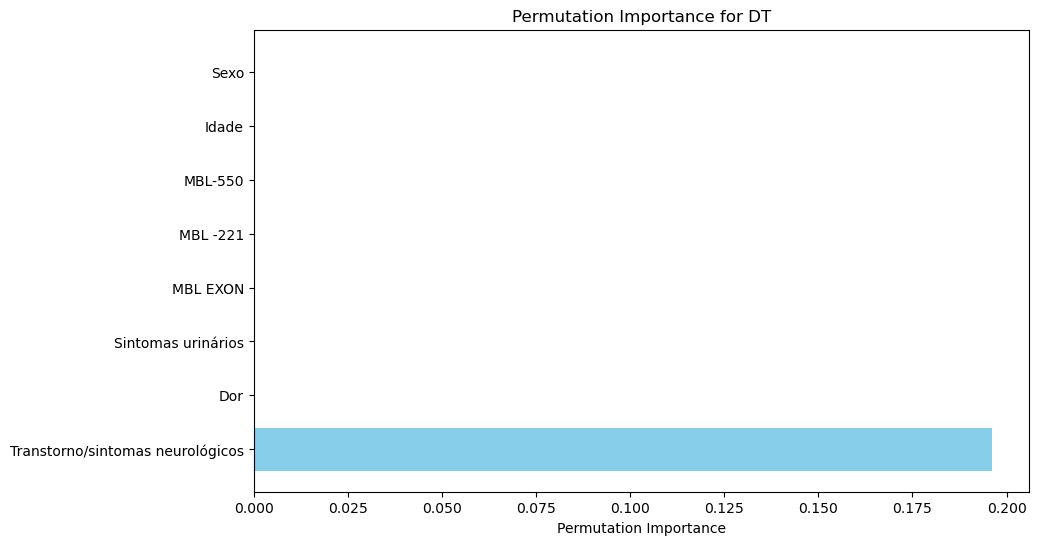

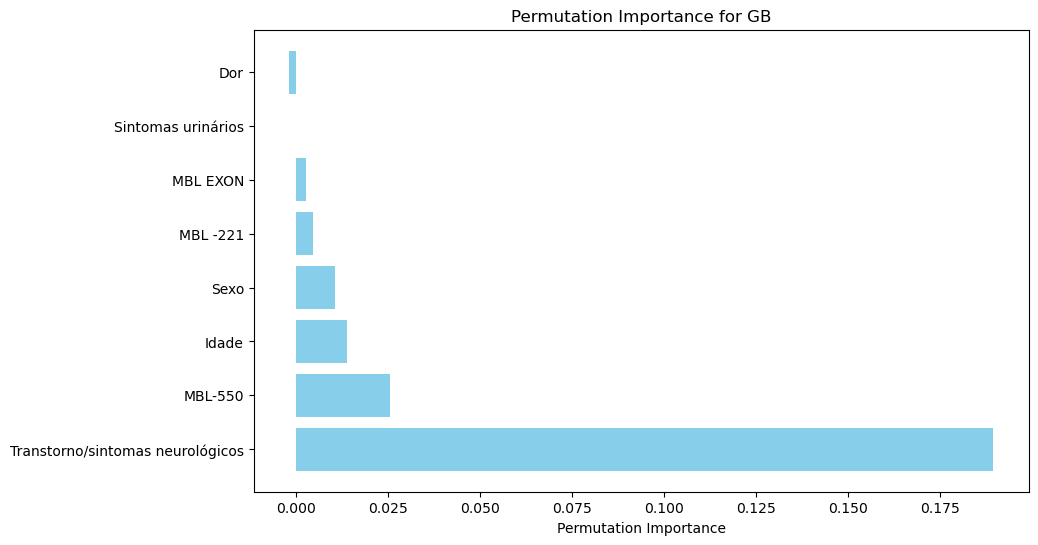

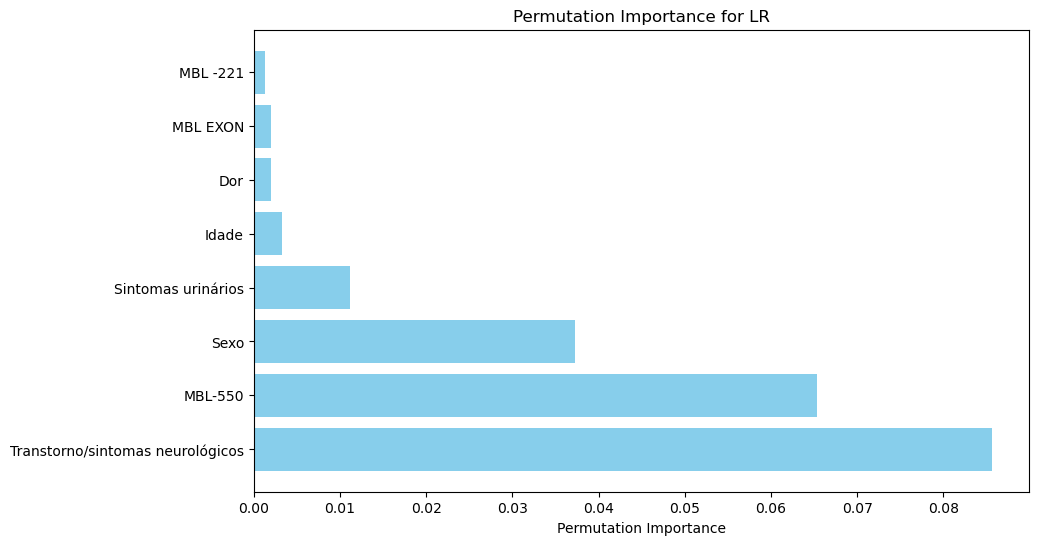

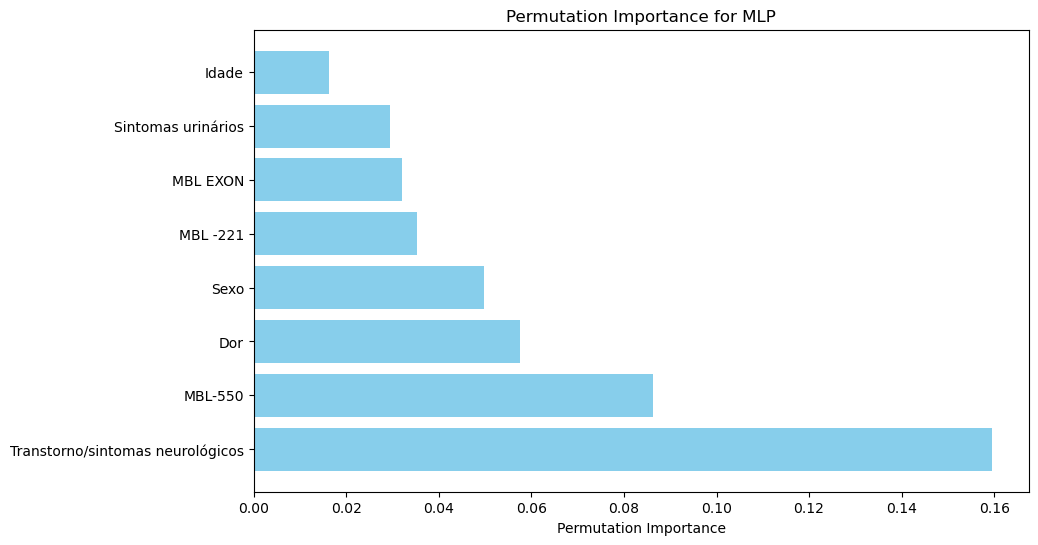

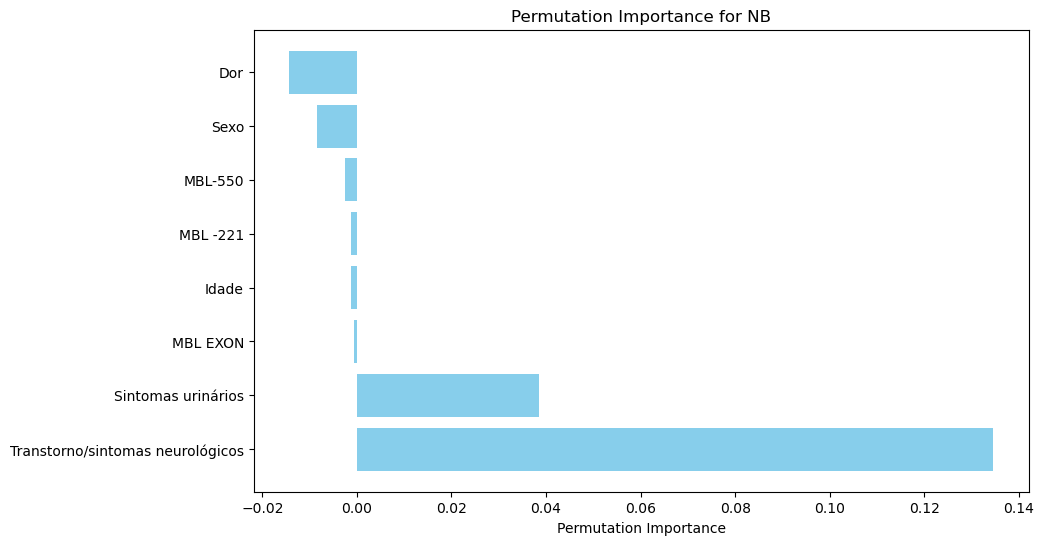

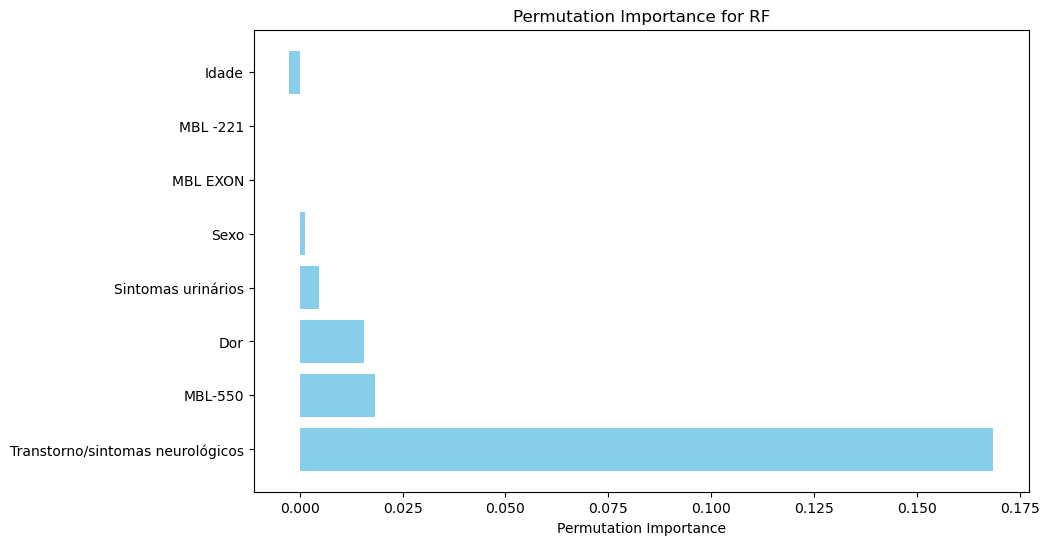

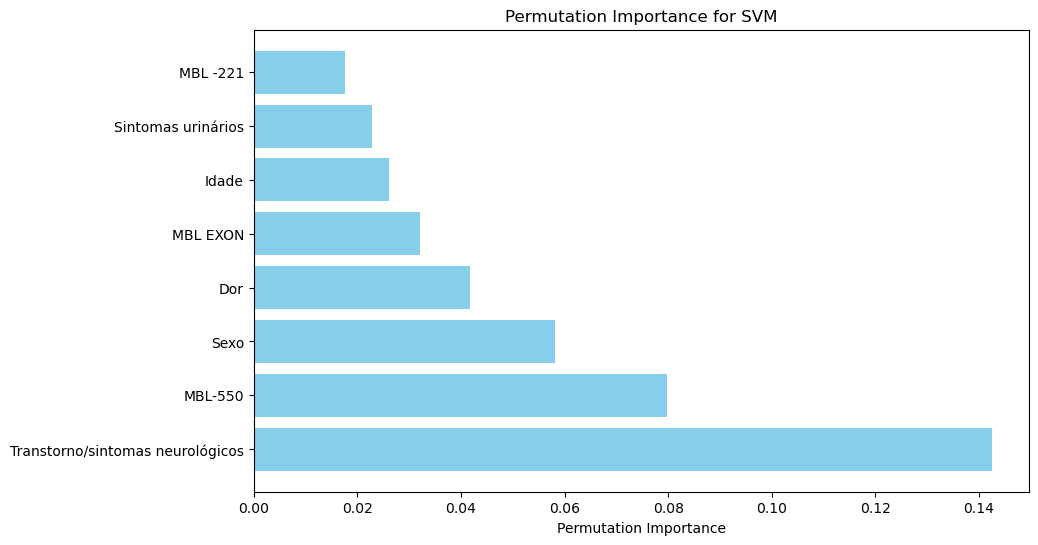

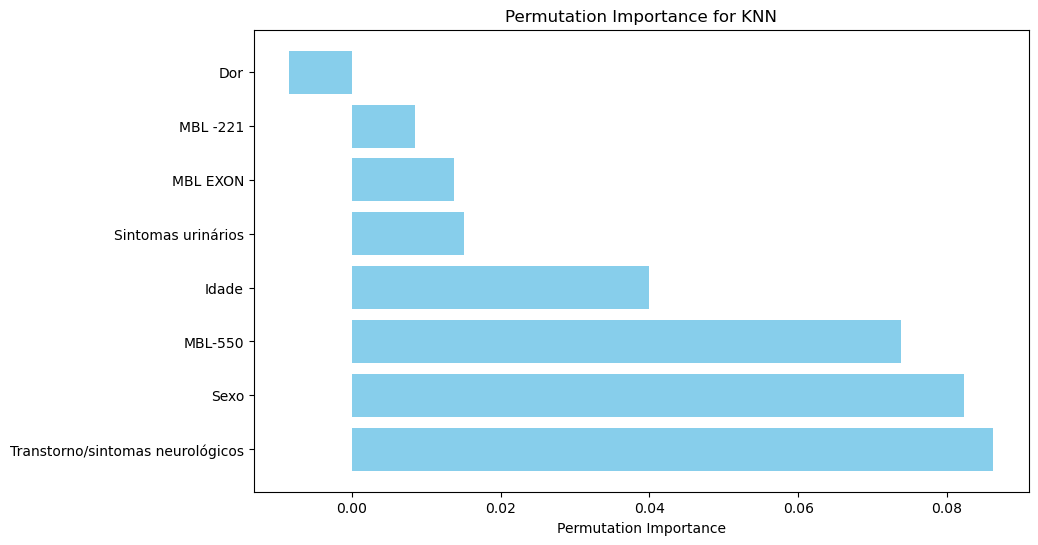

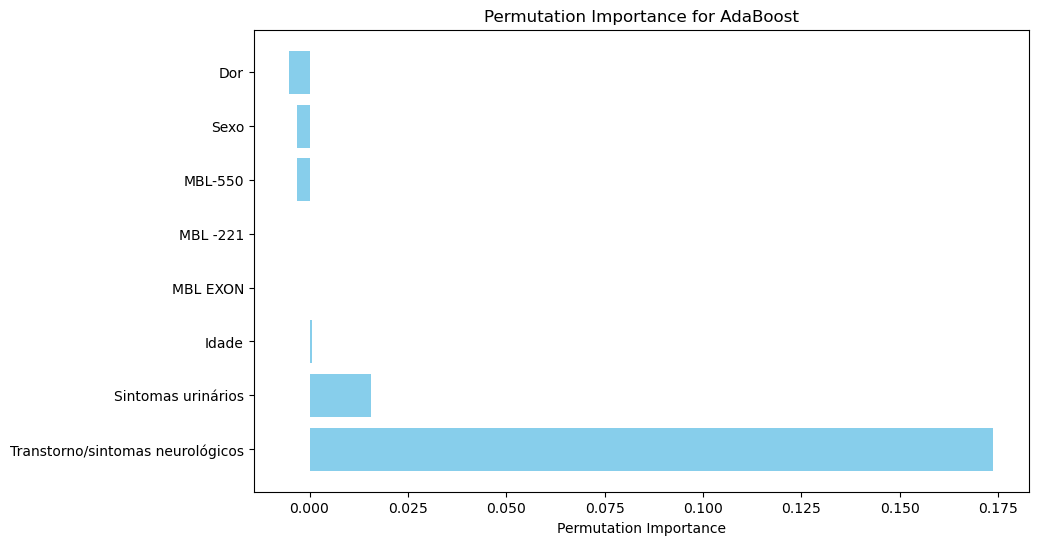

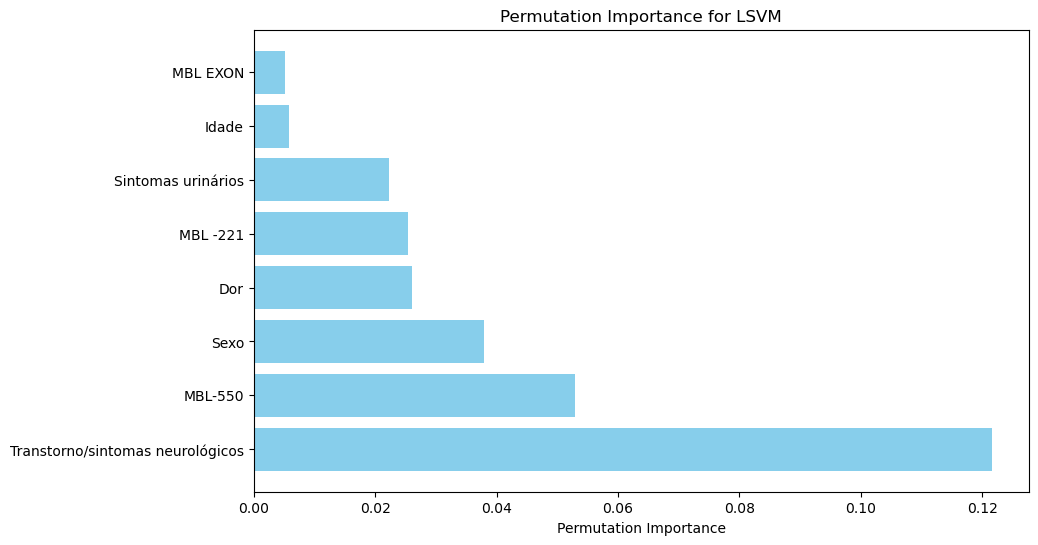

In [7]:
# Function to calculate and visualize the importance of characteristics for each model
def calculate_and_plot_permutation_importance(classifiers, X, y, save_dir=None):
    for model_name, model in classifiers.items():
        # Calculates the importance of characteristics
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)

        # Get the results
        sorted_idx = result.importances_mean.argsort()

        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], color='skyblue')
        plt.xlabel("Permutation Importance")
        plt.title(f"Permutation Importance for {model_name}")
        plt.gca().invert_yaxis()
        
        # Saves the image if the save directory is specified
        if save_dir:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            plt.savefig(os.path.join(save_dir, f'permutation_importance_{model_name}.png'))

        plt.show()

calculate_and_plot_permutation_importance(classifiers, X, y, save_dir='..\\XAI\\')


Importância das Características do modelo DT


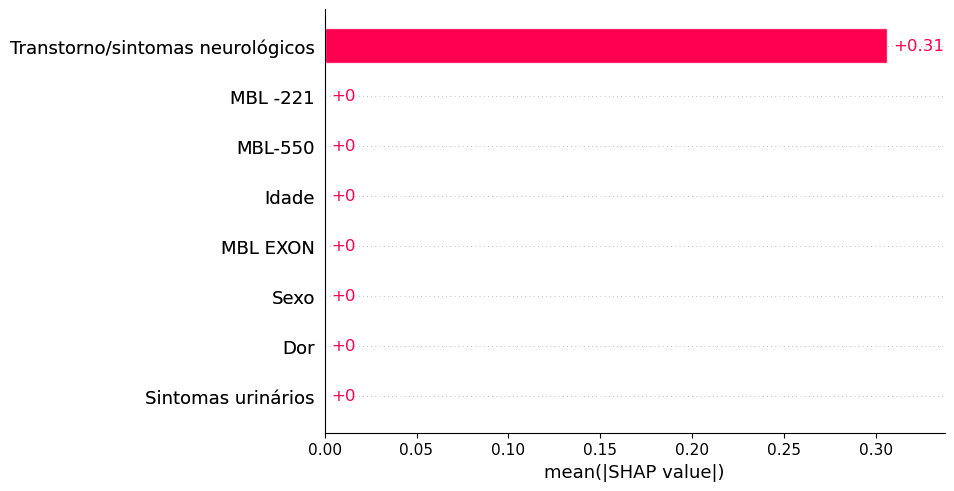

Importância das Características do modelo GB


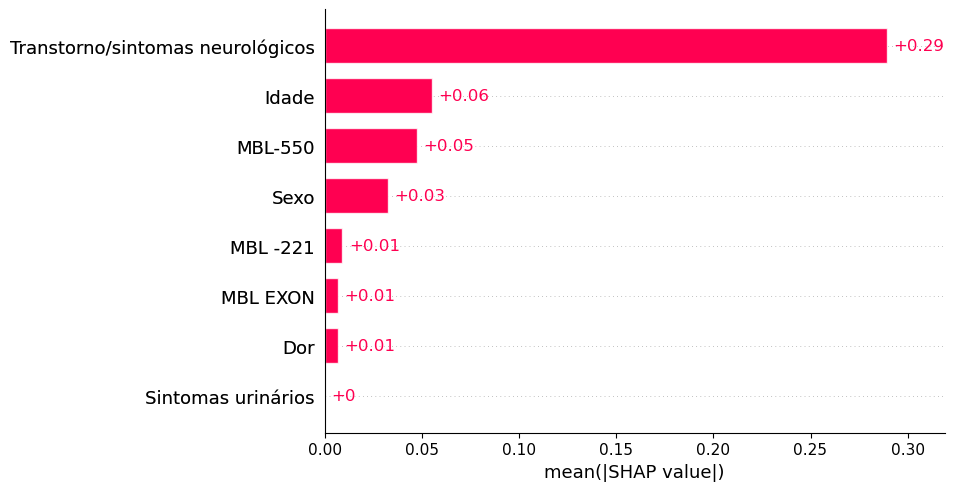

Importância das Características do modelo LR


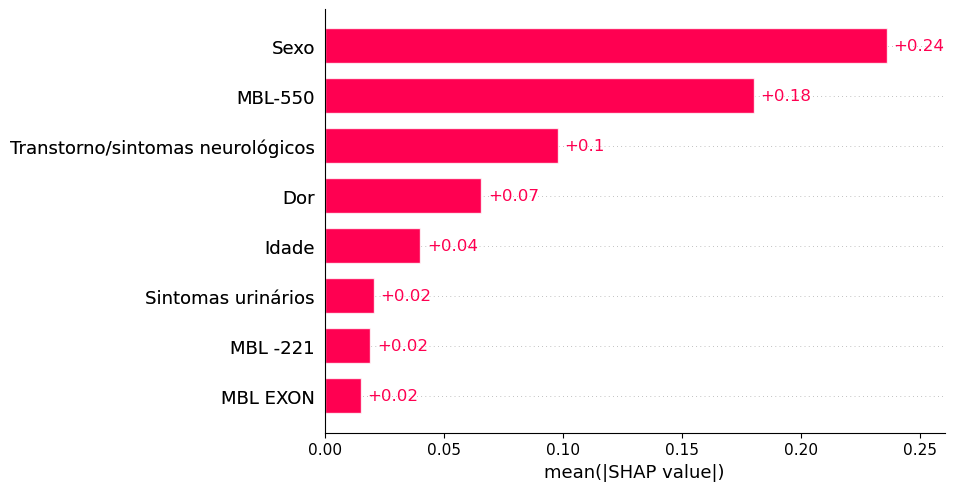

Importância das Características do modelo MLP


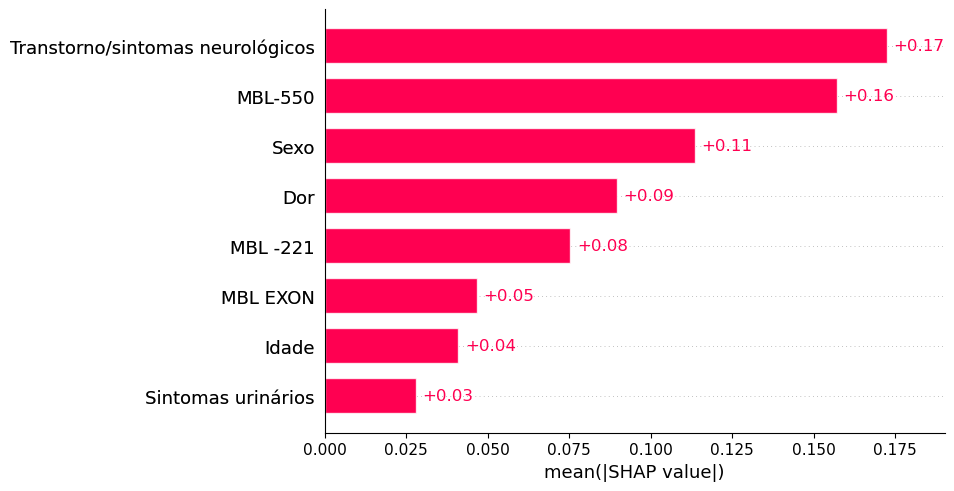

Importância das Características do modelo NB


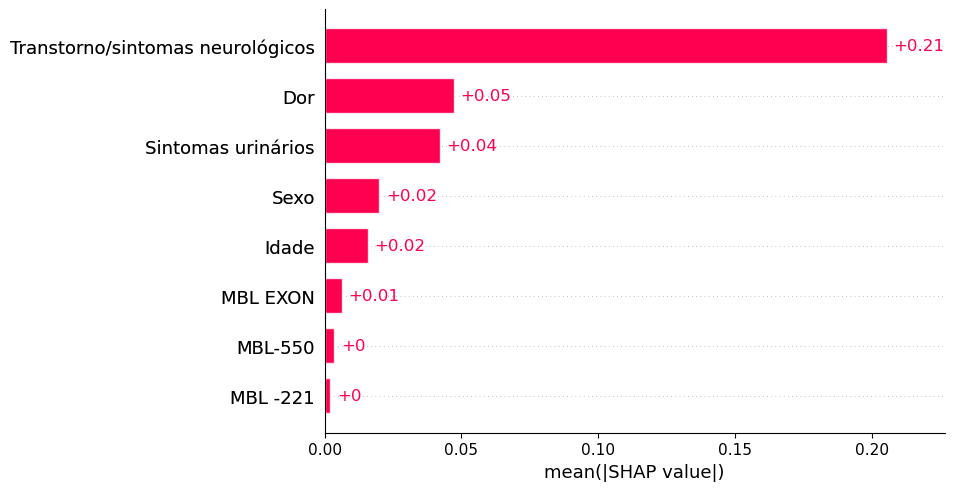

ExactExplainer explainer: 154it [00:10,  5.09s/it]                 


Importância das Características do modelo RF


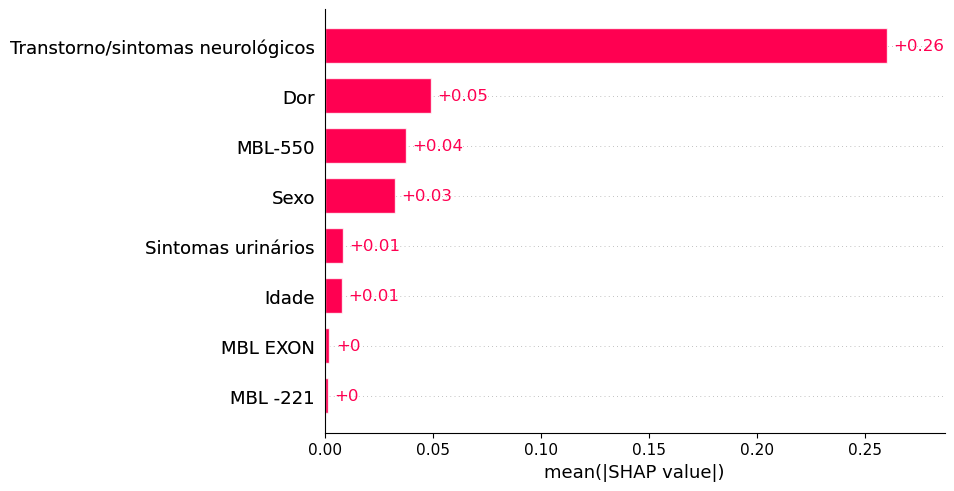

Importância das Características do modelo SVM


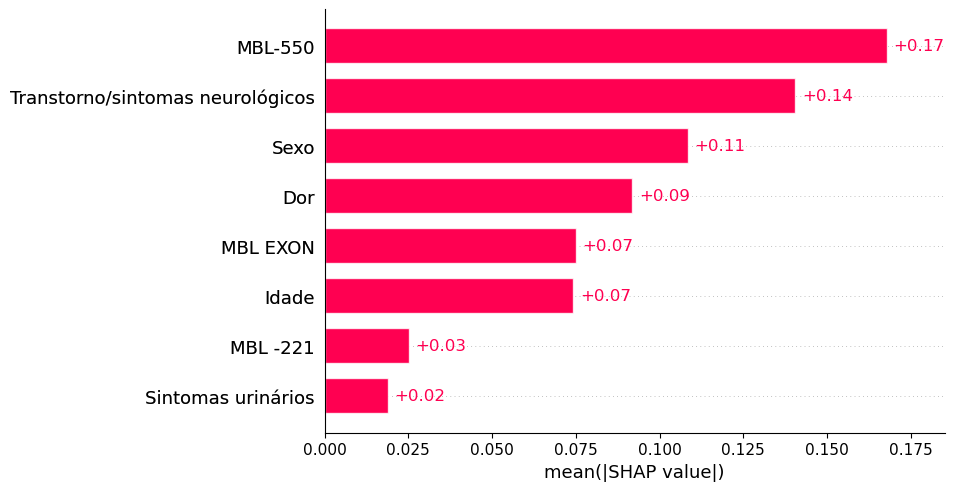

ExactExplainer explainer: 154it [01:13,  1.72it/s]                         


Importância das Características do modelo KNN


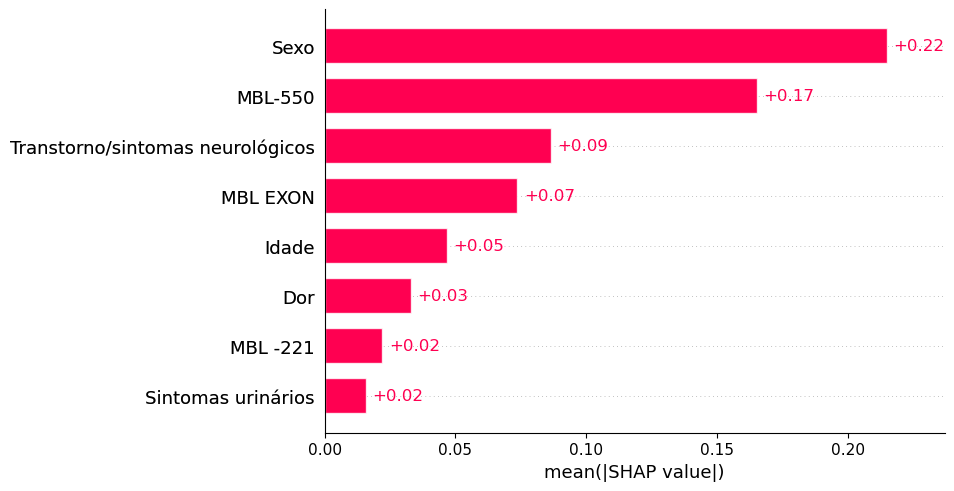

ExactExplainer explainer: 154it [01:37,  1.45it/s]                         


Importância das Características do modelo AdaBoost


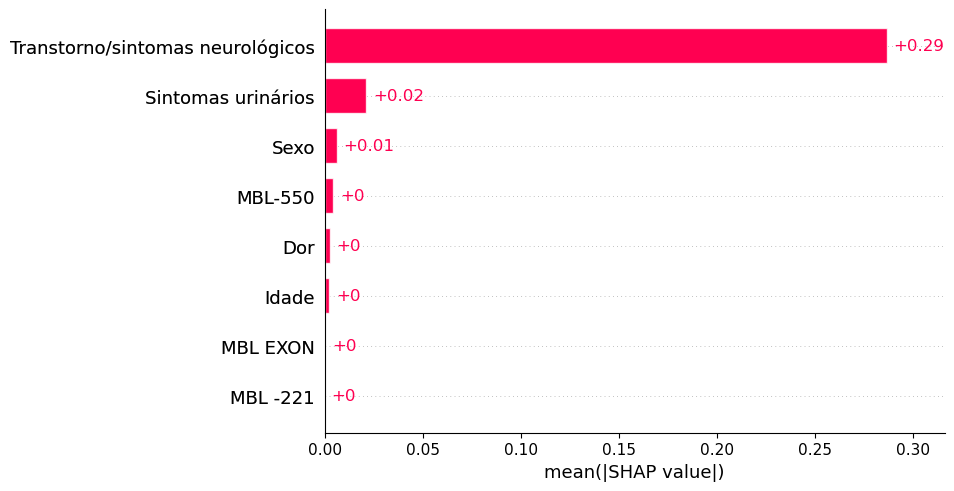

Importância das Características do modelo LSVM


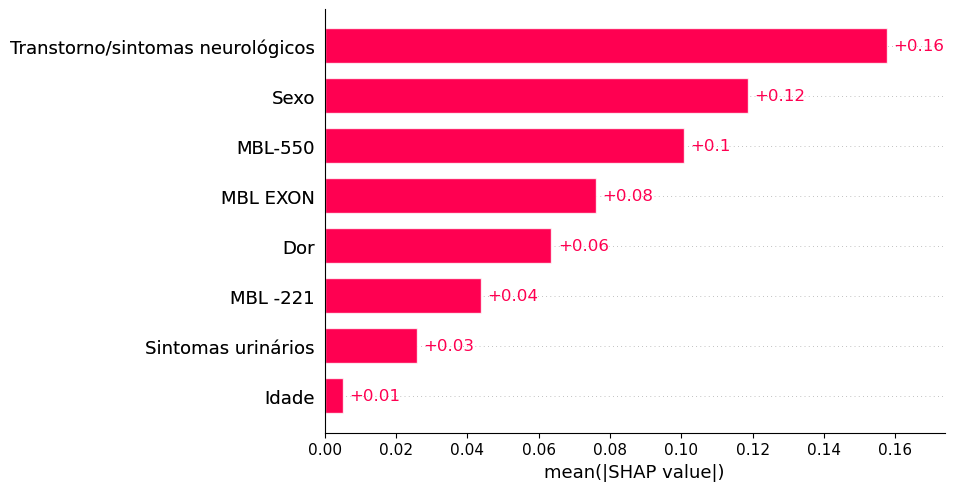

In [4]:
# Training the classifiers
for model_name, item in classifiers.items():

    # Training model
    item.fit(X, y)

    # Create an explainer object
    explainer = shap.Explainer(item.predict, X)

    # Calculate SHAP values
    shap_values = explainer(X)
    
    # Plot SHAP summary plot
    print(f'Importância das Características do modelo {model_name}')
    shap.plots.bar(shap_values)
